# Project Notebook: IMDB ratings 

The pointof this project is to test different models on how well they can peform. A KNN Regression and Ensembles...

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import re
import copy

import sys
import os
import pathlib
import glob

from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn import metrics

from os import listdir
from os.path import isfile, join

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6178 entries, 0 to 6177
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Name         6178 non-null   object
 1   Date         6178 non-null   int64 
 2   Rate         6178 non-null   object
 3   Votes        6178 non-null   object
 4   Genre        6178 non-null   object
 5   Duration     6178 non-null   object
 6   Type         6178 non-null   object
 7   Certificate  6178 non-null   object
 8   Episodes     6178 non-null   object
 9   Nudity       6178 non-null   object
 10  Violence     6178 non-null   object
 11  Profanity    6178 non-null   object
 12  Alcohol      6178 non-null   object
 13  Frightening  6178 non-null   object
dtypes: int64(1), object(13)
memory usage: 675.8+ KB
None
147
300
231
24 / 42
40 / 231


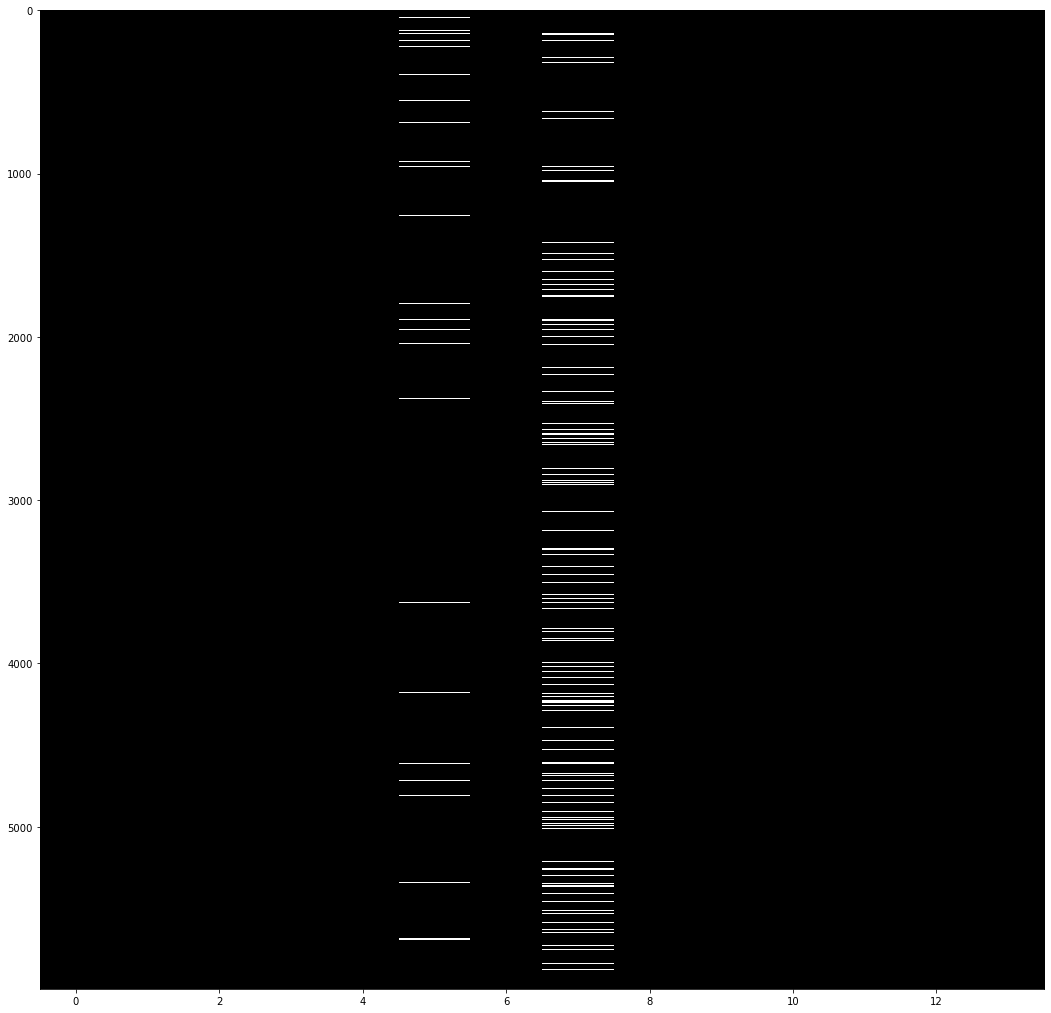

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5993 entries, 0 to 6177
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Name         5993 non-null   object
 1   Date         5993 non-null   int64 
 2   Rate         5993 non-null   object
 3   Votes        5993 non-null   object
 4   Genre        5993 non-null   object
 5   Duration     5846 non-null   object
 6   Type         5993 non-null   object
 7   Certificate  5422 non-null   object
 8   Episodes     5993 non-null   object
 9   Nudity       5993 non-null   object
 10  Violence     5993 non-null   object
 11  Profanity    5993 non-null   object
 12  Alcohol      5993 non-null   object
 13  Frightening  5993 non-null   object
dtypes: int64(1), object(13)
memory usage: 702.3+ KB
None


In [2]:
data0 = pd.read_csv("data/imdb.csv",
                    delimiter=',',
                   #na_values=['None']
                   )


data0_m = pd.read_csv("data/imdb.csv",
                     delimiter=',',
                     #na_values=['None']
                     )

print(data0_m.info())

data0 = data0.drop(data0.index.values[(data0['Rate'] == 'No Rate')],axis=0)
data0_m = data0_m.drop(data0_m.index.values[(data0_m['Rate'] == 'No Rate')], axis=0)

print(sum(data0_m['Duration'] == 'None'))
print(sum(data0_m['Certificate'] == 'None'))
print(sum(data0_m['Certificate'] == 'Not Rated'))
print(sum(data0_m['Certificate'] == 'Passed'), "/",sum(data0_m['Certificate'] == 'Approved') )
print(sum(data0_m['Certificate'] == 'Unrated'), "/",sum(data0_m['Certificate'] == 'Not Rated') )

#find the 'hidden' nans for this dataset
data0_m['Duration'] = data0_m['Duration'].replace('None', np.nan)
#https://movies.stackexchange.com/questions/65430/what-are-the-meanings-of-the-terms-passed-and-approved-with-regards-to-a-mov
#what the hell is the difference
data0_m['Certificate'] = data0_m['Certificate'].replace('None', np.nan)
data0_m['Certificate'] = data0_m['Certificate'].replace('Unrated', np.nan)
data0_m['Certificate'] = data0_m['Certificate'].replace('Not Rated', np.nan)
data0_m['Certificate'] = data0_m['Certificate'].replace('Passed', 'Approved')

#replacing stuff
data0_m['Episodes'] = data0_m['Episodes'].replace('-', '1 ')

"""
TV-Y: Designed to be appropriate for all children

TV-Y7: Suitable for ages 7 and up

G: Suitable for General Audiences
TV-G: Suitable for General Audiences

PG: Parental Guidance suggested
TV-PG: Parental Guidance suggested


PG-13: Parents strongly cautioned. May be Inappropriate for ages 12 and under.
TV-14: Parents strongly cautioned. May not be suitable for ages 14 and under.
M : not recommended for children under the age of 15

R: Restricted. May be inappropriate for ages 17 and under.
TV-MA: For Mature Audiences. May not be suitable for ages 17 and under.
NC-17: Inappropriate for ages 17 and under


TV-G is the same as G which is approved
R and TV-MA is the same
TV-PG, GP, M, TV-MA, R is the same thing
TV-Y is approved
approved is E

"""

certs = np.array(['PG-13',    # X
                  'R',        # X
                  'TV-MA',    # X
                  'TV-14',    # X
                  'TV-PG',    # X
                  'PG',       # X
                  '(Banned)', # this is the last one  as  none should watch it :)
                  'TV-G',     # X
                  'E' ,       # -> 'approved'  , british was of saying it
                  'NC-17',    # X
                  'TV-Y7-FV', # -> TV-Y7
                  'TV-Y7',    # X
                  'Approved', # X this the lowest
                  'G' ,       # X
                  'TV-Y',     # X
                  'GP',       # -> PG
                  'M',        # X
                  'X',        # -> NC-17
                  'M/PG'],    # PG
                 dtype='object')

data0_m['Certificate'] = data0_m['Certificate'].replace(['Approved', 'E'], ['G', 'G'])
data0_m['Certificate'] = data0_m['Certificate'].replace(['TV-G', 'G'], ['G', 'G'])
data0_m['Certificate'] = data0_m['Certificate'].replace(['M/PG', 'M'], ['M', 'M'])
data0_m['Certificate'] = data0_m['Certificate'].replace(['TV-PG', 'PG', 'GP'], ['PG', 'PG', 'PG'])
data0_m['Certificate'] = data0_m['Certificate'].replace(['R', 'TV-MA', 'NC-17', 'X'], ['R', 'R', 'R', 'R'])
data0_m['Certificate'] = data0_m['Certificate'].replace('TV-G', 'G')
data0_m['Certificate'] = data0_m['Certificate'].replace('TV-Y7-FV', 'TV-Y7')


#how many nans?
fig,ax = plt.subplots(1,1,figsize=(18,18))
ax.imshow(data0_m.isna(), aspect='auto',interpolation='none',cmap="gray")
plt.show()

print(data0_m.info())

As it is visible, all of these are strings, which needs some encoding. Let's look at the different columns unique values!

In [3]:
for i in data0.columns:
    typ = pd.unique(data0_m[i].values)
    print("+------------------------------------------------------+\nColumn: \t  {} \n\t{}\n+======================================================+\n".format(i,typ))

+------------------------------------------------------+
Column: 	  Name 
	['No Time to Die' 'The Guilty' 'The Many Saints of Newark' ...
 "Before the Devil Knows You're Dead" 'Queen Bees' 'Death Race']
+======================================================+

+------------------------------------------------------+
Column: 	  Date 
	[2021 2015 2006 2020 2018 2012 1993 1984 2008 1978 2019 1997 2022 1995
 1996 2017 1999 2013 1994 2001 2007 1991 2016 2000 1972 1988 2014 1975
 2005 2009 1981 2002 2010 2004 1980 1962 1982 1992 1998 1969 1990 1985
 2003 1973 1971 1974 1987 2011 1979 1964 1986 1963 1989 1976 1983 1960
 1977 1957 1966 1968 1965 1953 1967 1950 1939 1948 1942 1961 1941 1954
 1931 1958 1946 1959 1956 1945 1935 1932 1927 1951 1922 1937 1952 1970
 1940 1955 1949 1933 2023 1943 1944]
+======================================================+

+------------------------------------------------------+
Column: 	  Rate 
	['7.6' '6.3' '6.4' '8.3' '8.8' '7.3' '8.2' '7.9' '7.4' '9.2' '8.0' '

In [4]:
print(len(pd.unique(data0['Genre'].values)))

377


**NAN VALUES**

There are mutliple type of NaN values, like, '-', 'No Rate', 'None'. These could mean different things for each column, so we have to go through what each column means.

Let's go through each column!

**Name**:

No issue here, we don't need any encoding, as the name of the movie/series is an unneeded informtion for our analysis.

**DATE**

This is information that is needed for us.

**RATE**

Target. What we want to predict!

**VOTES**

How many people voted for its rating.

**GENRE**

This has many, but it seems like there are overlappings. Maybe unfolding this into "isSCIFI" columns would be handy...
After checking, we only have like 27 genres, rather then \~400

**DURATION**

Lenght in minutes.

**TYPE**

Is it a movie or series.

**Certificate**

I don't know what are these, but it needs to be encoded.

**EPISODES**

How many episodes it got. Question is how much does it counted if a movie is a trilogy? 

**OTHERS** 

These are just some simple ways to categorize the film.

In [5]:
#preparing stuff
rgx = re.compile("([^,\s]+)")

genres = []
for i in range(len(data0['Genre'].values)):
    gens = rgx.findall(data0['Genre'].values[i])
    genres.append(gens)
    
genres = [item for sublist in genres for item in sublist]

#format the easier rows
data0_m['Votes'] = data0_m['Votes'].replace(to_replace=r'[\,]', value='', regex=True)


#format the genres
genre_list = pd.unique(genres)
my_d = {
    "genre" : genre_list,
    "encode": np.arange(len(genre_list))
}
print((my_d["genre"]))

for i in genres:
    data0_m[i] = copy.deepcopy(np.zeros(len(data0_m.index), dtype=np.uint8))

for i in range(len(data0.index)):
    #data0_m.iloc[2]["War"]
    row = data0['Genre'].values[i]
    gens = rgx.findall(row)
    if len(gens) != 0:
        for j in gens:
            data0_m.at[i,j] = 1

data0_m = data0_m.dropna(axis=0)
            
#encode others too!
#TYPE
data0_m['Type'] = data0_m['Type'].replace(['Film', 'Series'], [0,1])
#CERTIFICATE
data0_m['Certificate'] = data0_m['Certificate'].replace(['TV-Y', 'TV-Y7','G','PG','PG-13','TV-14','M','R','(Banned)'],
                                                        [0,1,2,3,4,5,6,7,8])

#I removed the nans too
nvpaf_encode = [1,0,2,3,np.nan]

#Nudity
data0_m['Nudity'] = data0_m['Nudity'].replace(['Mild', 'None', 'Moderate', 'Severe', 'No Rate'],
                                            [1,0,2,3,np.nan])
#Violence  
data0_m['Violence'] = data0_m['Violence'].replace(['Mild', 'None', 'Moderate', 'Severe', 'No Rate'],
                                            [1,0,2,3,np.nan])
#Profanity
data0_m['Profanity'] = data0_m['Profanity'].replace(['Mild', 'None', 'Moderate', 'Severe', 'No Rate'],
                                            [1,0,2,3,np.nan])
#Alcohol
data0_m['Alcohol'] = data0_m['Alcohol'].replace(['Mild', 'None', 'Moderate', 'Severe', 'No Rate'],
                                            [1,0,2,3,np.nan])
#Frightening
data0_m['Frightening'] = data0_m['Frightening'].replace(['Mild', 'None', 'Moderate', 'Severe', 'No Rate'],
                                            [1,0,2,3,np.nan])

#data0_m = data0_m.drop(columns=['Genre','Name'])

#dropna again
data0_m = data0_m.dropna(axis=0)


#format to numeric

data0_m['Date'] = pd.to_numeric(data0_m['Date'],downcast="integer")
data0_m['Rate'] = pd.to_numeric(data0_m['Rate'])
data0_m['Votes'] = pd.to_numeric(data0_m['Votes'],downcast="integer")
data0_m['Duration'] = pd.to_numeric(data0_m['Duration'],downcast="integer")
data0_m['Episodes'] = pd.to_numeric(data0_m['Episodes'],downcast="integer")
for i in genre_list:
    data0_m[i] = pd.to_numeric(data0_m[i], downcast="integer")

#get names and target
names = data0_m['Name']
target = data0_m['Rate']

data0_m = data0_m.drop(columns=['Genre', 'Name', 'Rate'])

['Action' 'Adventure' 'Thriller' 'Crime' 'Drama' 'Sci-Fi' 'Comedy' 'Sport'
 'Animation' 'Horror' 'Mystery' 'Romance' 'History' 'Fantasy' 'Biography'
 'Family' 'Western' 'Musical' 'Music' 'War' 'Short' 'Reality-TV'
 'Documentary' 'Film-Noir' 'Game-Show' 'Talk-Show' 'News']


<class 'pandas.core.frame.DataFrame'>
Int64Index: 4947 entries, 0 to 6177
Data columns (total 38 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Date         4947 non-null   int16  
 1   Votes        4947 non-null   int32  
 2   Duration     4947 non-null   int16  
 3   Type         4947 non-null   int64  
 4   Certificate  4947 non-null   int64  
 5   Episodes     4947 non-null   int16  
 6   Nudity       4947 non-null   float64
 7   Violence     4947 non-null   float64
 8   Profanity    4947 non-null   float64
 9   Alcohol      4947 non-null   float64
 10  Frightening  4947 non-null   float64
 11  Action       4947 non-null   int8   
 12  Adventure    4947 non-null   int8   
 13  Thriller     4947 non-null   int8   
 14  Crime        4947 non-null   int8   
 15  Drama        4947 non-null   int8   
 16  Sci-Fi       4947 non-null   int8   
 17  Comedy       4947 non-null   int8   
 18  Sport        4947 non-null   int8   
 19  Animat

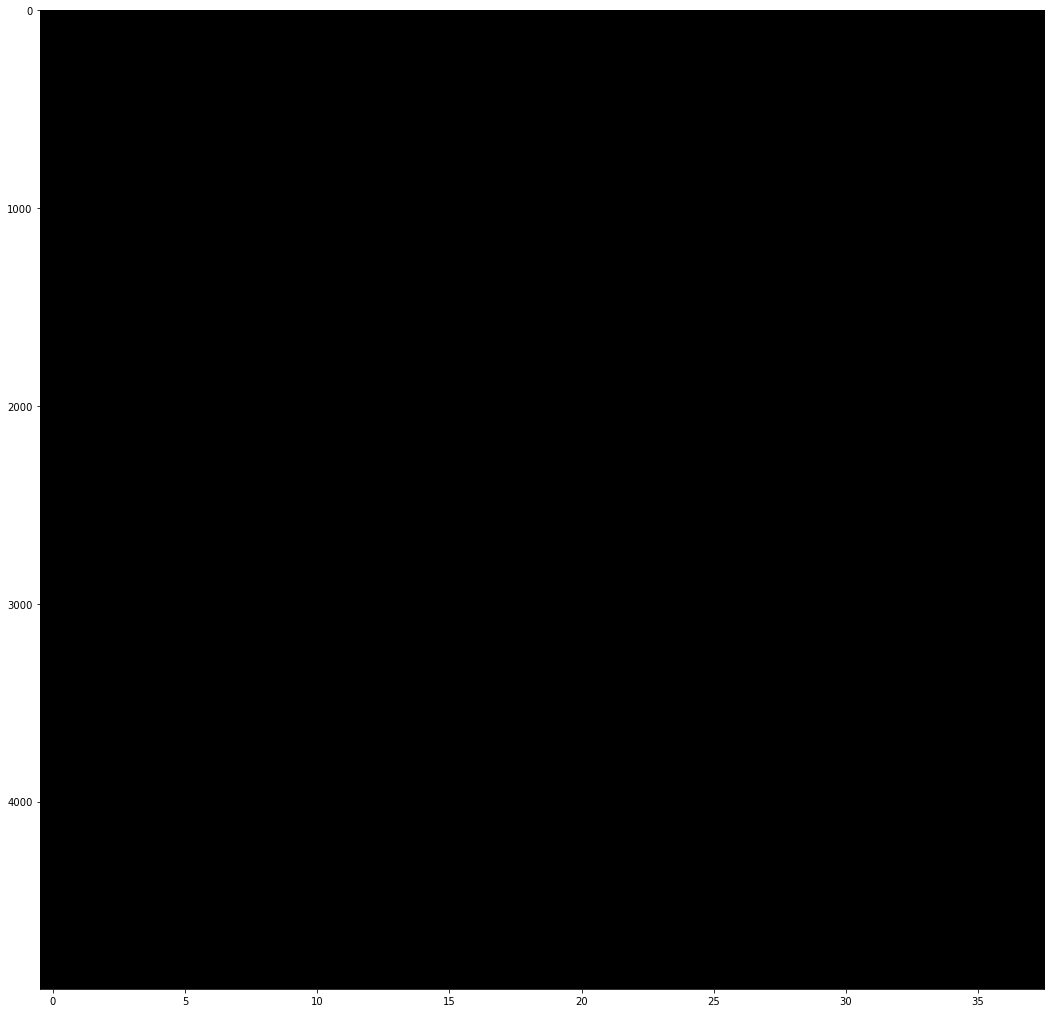

In [6]:
print(data0_m.info())

fig,ax = plt.subplots(1,1,figsize=(18,18))
ax.imshow(data0_m.isna(), aspect='auto',interpolation='none',cmap="gray")
plt.show()

Data cleansing is done, onto the real stuff: **MACHINE LEARNING**!

# KNN Regression

In [7]:
from sklearn.neighbors import KNeighborsRegressor

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn import metrics

In [14]:
def accuracy_comp(arr1,arr2):
    assert len(arr1) == len(arr2), "Mismatching sizes of arrays"
    sub_acc = 0
    for i in range(len(arr1)):
        if(arr1[i] == arr2[i]):
            sub_acc += 1
    return sub_acc / len(arr1)

def plot_hist_n_scatter(arr1,arr2,fig_name):
    
    #histogram plot
    bars1, edges1 = np.histogram(arr1,np.linspace(0,10,101))
    bars2, edges2 = np.histogram(arr2,np.linspace(0,10,101))

    cents1 = edges1[:-1]/2 + edges1[1:]/2
    step0 = (edges2[1] + edges2[0])/2

    fig,ax = plt.subplots(1,1,figsize=(10,6))

    ax.set_title(fig_name+"\nAccuracy: {0:.3f}%, R2 score: {1:.3f}".format(accuracy_comp(arr2.values,np.round(arr1,1))*100, metrics.r2_score(arr2.values,arr1)),
                fontsize=24)

    ax.hist(np.round(arr1,1), bins=edges1, alpha=0.4, label='Prediction')
    ax.hist(arr2, bins=edges2, alpha=0.4, label='Test')

    ax.set_xlabel("Rating", fontsize=24)
    ax.set_ylabel("Occurence", fontsize=24)
    ax.set_xlim(-0.1,10.1)

    ax.tick_params(axis="both", labelsize=18)
    ax.legend(loc='upper left', fontsize=22)

    ax.grid(linestyle=':')

    fig.tight_layout()
    plt.show()
    
    
    #scatter plot
    fig,ax = plt.subplots(1,1,figsize=(10,10))

    ax.set_title(fig_name+"\nPredicted and True Ratings", fontsize=24)

    ax.plot(np.round(arr1,1),arr2, " ro", alpha=0.2)
    ax.plot([-0.1,10.1],[-0.1,10.1], "--b")

    ax.set_xlim(-0.1,10.1)
    ax.set_ylim(-0.1,10.1)
    ax.set_xlabel("True Rating", fontsize=24)
    ax.set_ylabel("Predicted Rating", fontsize=24)

    ax.tick_params(axis="both", labelsize=18)
    ax.grid(linestyle=":")
    fig.tight_layout()
    plt.show()

In [12]:
scaler= StandardScaler()
X_train, X_test, y_train, y_test = train_test_split(data0_m,
                                                    target,
                                                    test_size=0.2,
                                                    random_state=276
                                                   )

0.24492758655569036


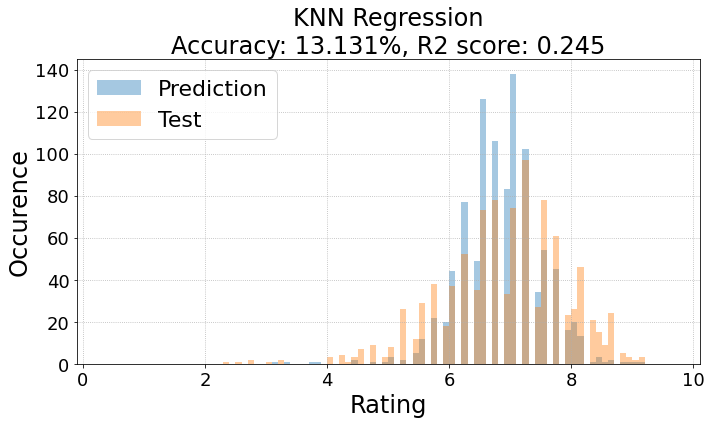

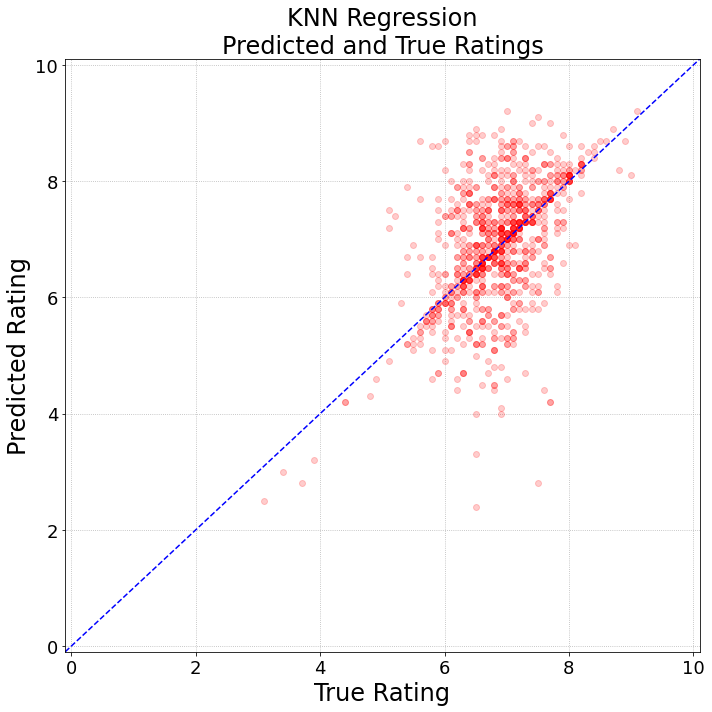

In [15]:
KNNR = KNeighborsRegressor(n_neighbors=10, n_jobs=-1, p=1.5,weights='distance')
KNNR.fit(X_train, y_train)
y_pred = KNNR.predict(X_test)

print(KNNR.score(X_test,y_test))

plot_hist_n_scatter(y_pred,y_test,"KNN Regression")

-3.909870292672892


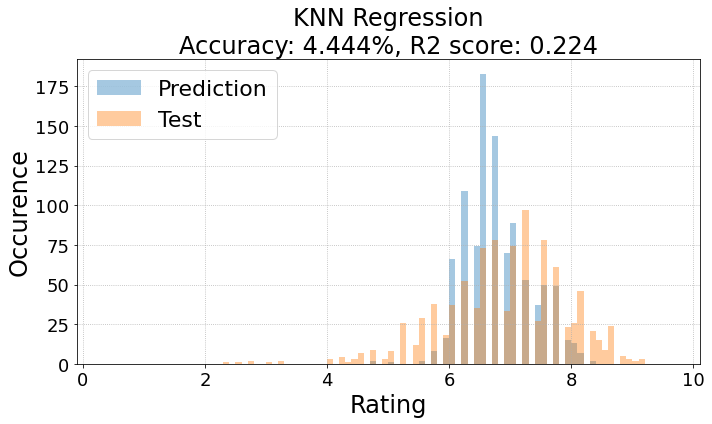

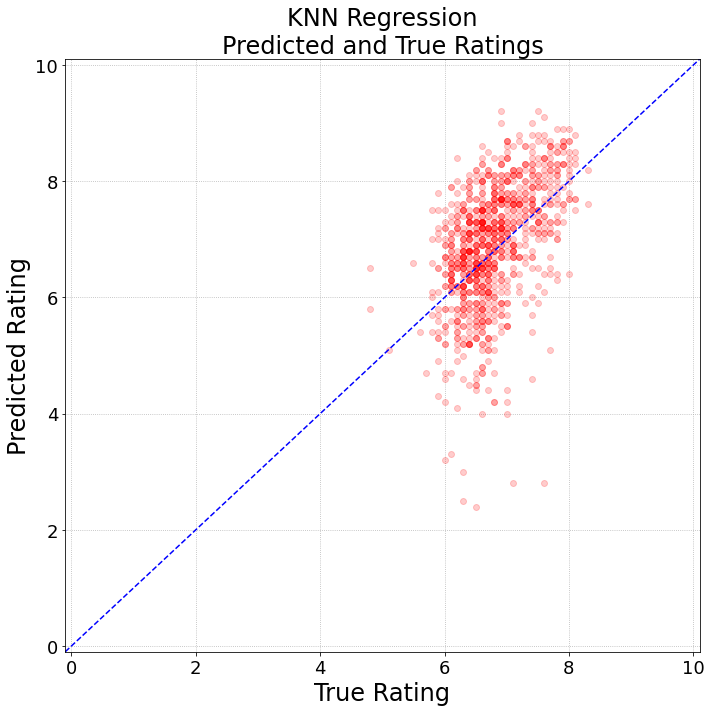

In [16]:
scaler.fit(X_train)
X_train_s = scaler.transform(X_train)
X_test_s = scaler.transform(X_test)

KNNR = KNeighborsRegressor(n_neighbors=10, n_jobs=-1, p=1.5,weights='distance')
KNNR.fit(X_train_s, y_train)
y_pred = KNNR.predict(X_test_s)

print(KNNR.score(X_test,y_test))

plot_hist_n_scatter(y_pred,y_test,"KNN Regression")

This was the first, easiest to understand and somewhat inaccurate model to implement. Also, StandardScaling actually made it way worse. Maybe giving more influence to "isSci-fi" like rows is not benefical to the analysis.

# Linear Regression

In [17]:
from sklearn.linear_model import LinearRegression

0.38616846495941703


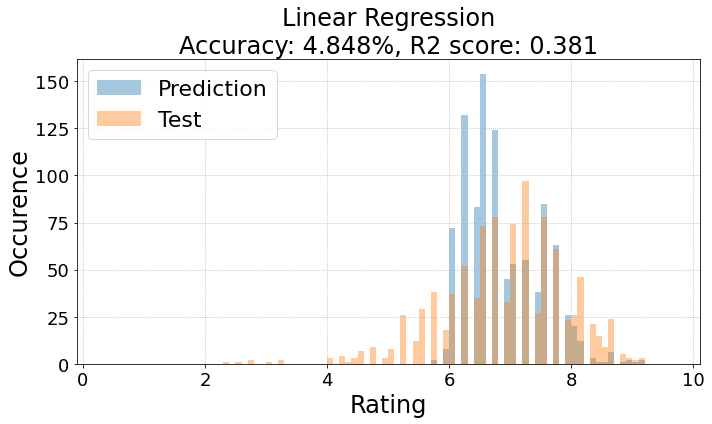

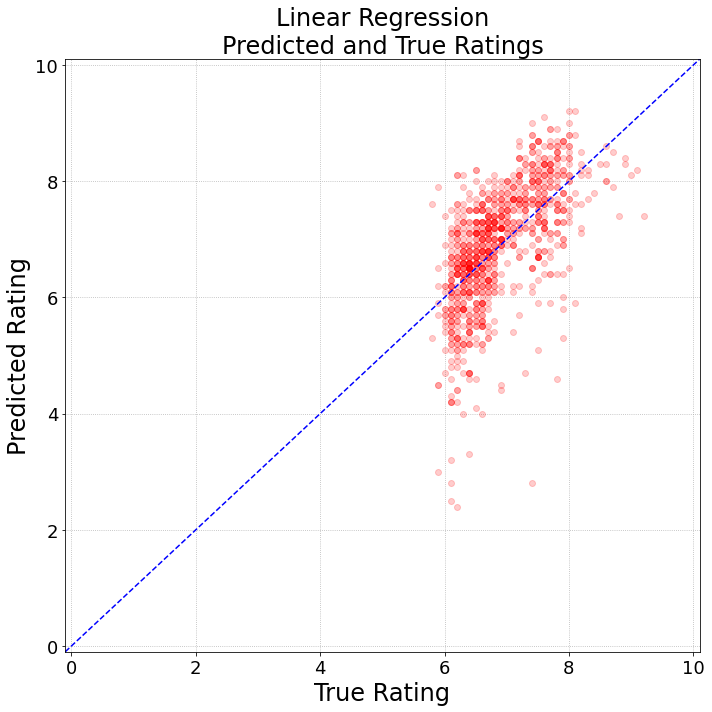

In [18]:
LR = LinearRegression(n_jobs=-1)
LR.fit(X_train.values, y_train)
y_pred = np.round(LR.predict(X_test),1)

print(LR.score(X_test,y_test))

plot_hist_n_scatter(y_pred,y_test, "Linear Regression")

-8835383831.716616


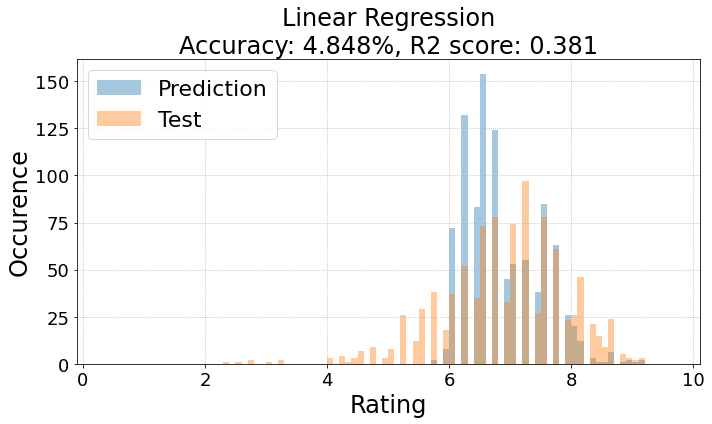

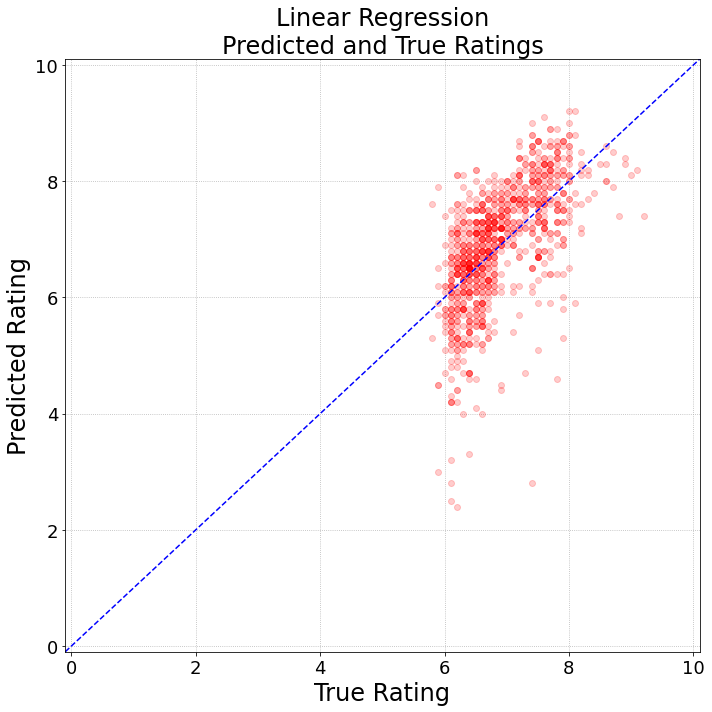

In [19]:
LR = LinearRegression(n_jobs=-1)
LR.fit(X_train_s, y_train)
y_pred = np.round(LR.predict(X_test_s),1)

print(LR.score(X_test,y_test))

plot_hist_n_scatter(y_pred,y_test, "Linear Regression")

# Ridge

In [20]:
from sklearn.linear_model import Ridge      

0.3861687536862427


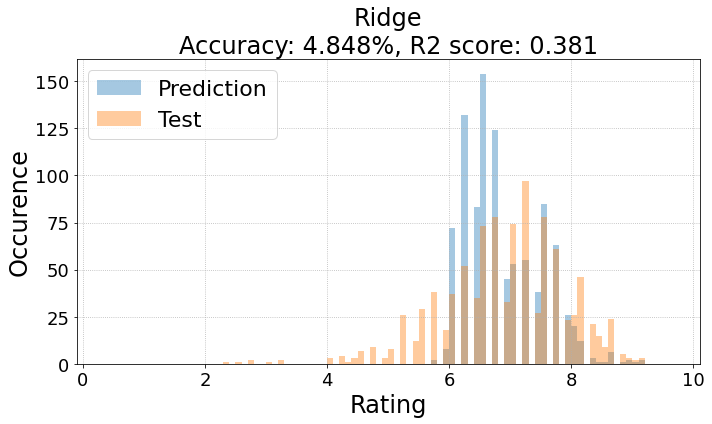

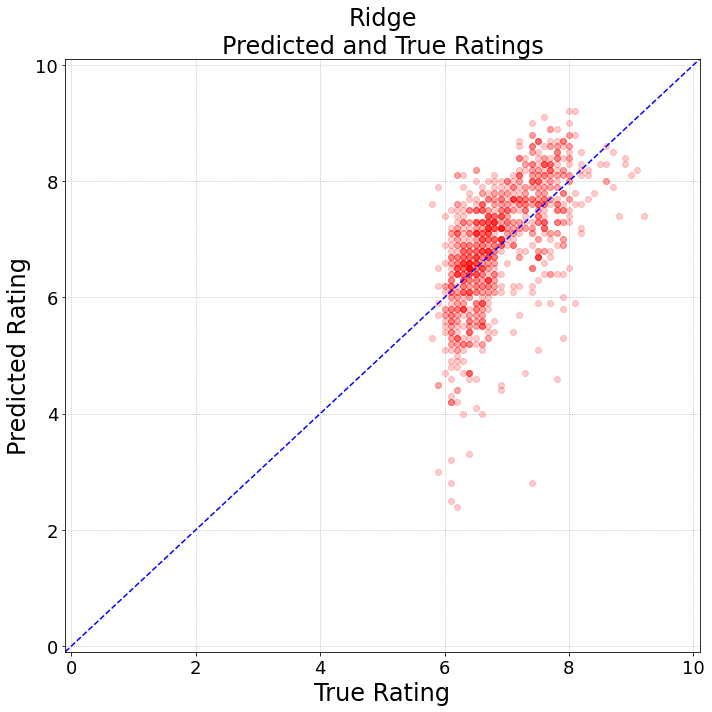

In [33]:
RID = Ridge(alpha=1e-4,solver='svd')
RID.fit(X_train,y_train)
y_predr = np.round(RID.predict(X_test),1)

print(RID.score(X_test,y_test))

plot_hist_n_scatter(y_predr,y_test, "Ridge")

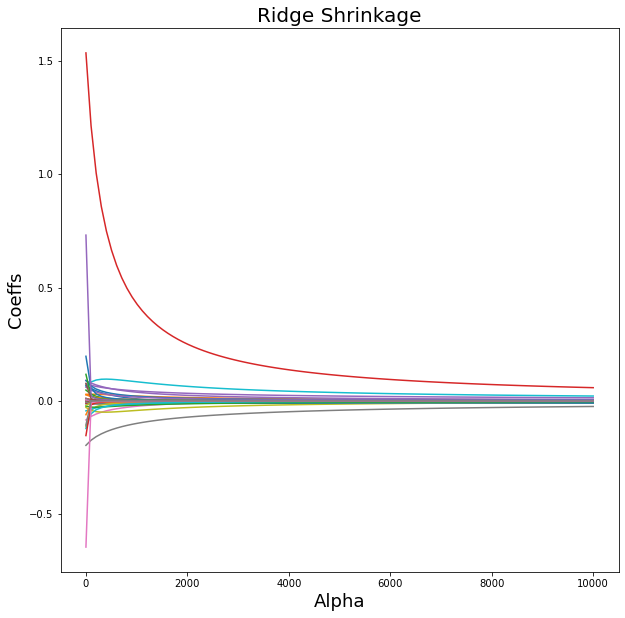

In [34]:
all_coeffs = []
alphas = []

for a in np.linspace(0.1, 10000, 100):
    alphas.append(a)
    r = Ridge(alpha=a)
    r.fit(X_train, y_train)
    all_coeffs.append(r.coef_)
    
all_coeffs = np.array(all_coeffs)

plt.figure(figsize=(10,10))
plt.plot(alphas, all_coeffs)
plt.title("Ridge Shrinkage", fontsize=20)
plt.xlabel("Alpha", fontsize=18)
plt.ylabel("Coeffs", fontsize=18)
plt.show()


# ElasticNet

In [35]:
from sklearn.linear_model import ElasticNet

0.36162418531582996


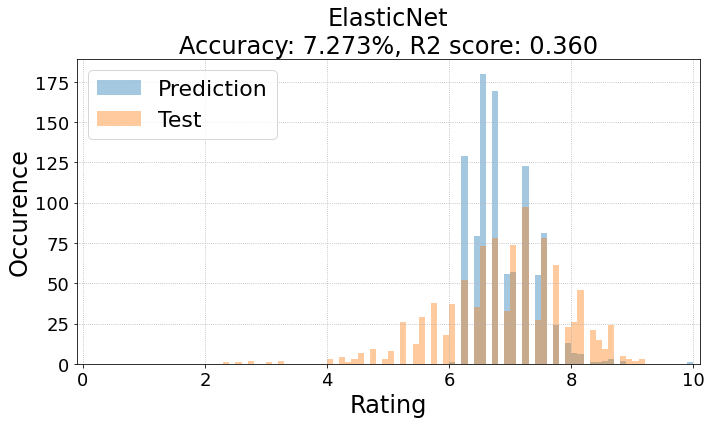

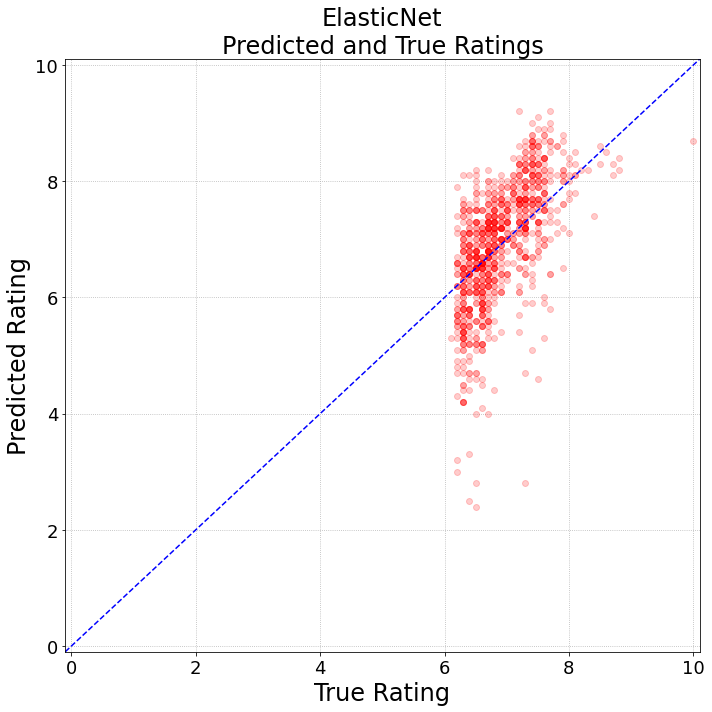

In [36]:
EN = ElasticNet(alpha=0.05,random_state=276,l1_ratio=0.86)
EN.fit(X_train, y_train)
y_pred = np.round(EN.predict(X_test),1)

print(EN.score(X_test,y_test))

plot_hist_n_scatter(y_pred,y_test, "ElasticNet")

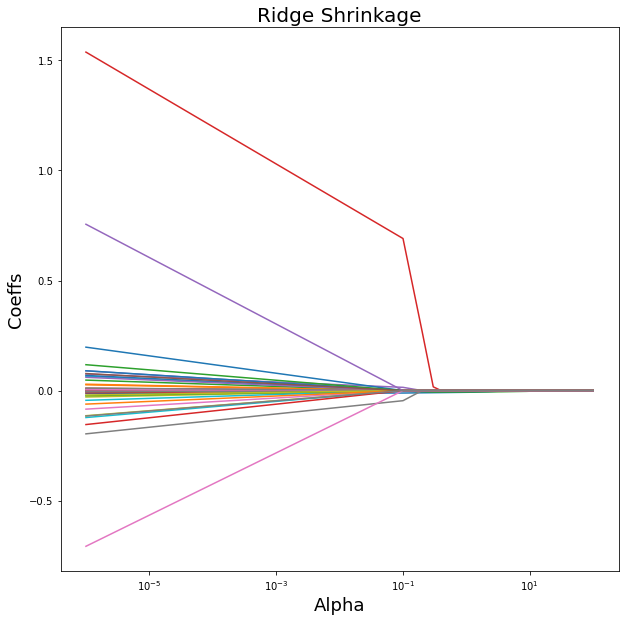

In [37]:
all_coeffs = []
alphas = []

for a in np.linspace(1e-6, 100, 1000):
    alphas.append(a)
    r = ElasticNet(alpha=a)
    r.fit(X_train, y_train)
    all_coeffs.append(r.coef_)
    
all_coeffs = np.array(all_coeffs)

plt.figure(figsize=(10,10))
plt.plot(alphas, all_coeffs)
plt.title("Ridge Shrinkage", fontsize=20)
plt.xlabel("Alpha", fontsize=18)
plt.ylabel("Coeffs", fontsize=18)
plt.xscale("log")
plt.show()

# ElasticCV

Let's see what are the most important features according to this.

In [38]:
from sklearn.linear_model import ElasticNetCV as ECV
from sklearn.feature_selection import RFE as RFE

In [39]:
ECV_e = ECV(alphas=[1e-3, 1e-2, 1e-1, 1], cv=5)

ECV_selector = RFE(ECV_e, n_features_to_select=10)

ECV_selector.fit(X_train,y_train)

for i in range(10):
    print(data0_m.columns[ECV_selector.support_][i], "\t\t", ECV_selector.estimator_.coef_[i])

Type 		 0.9917872904278819
Nudity 		 -0.05993602227031704
Violence 		 -0.12985111493275336
Alcohol 		 0.10052247191907274
Frightening 		 0.10995226092034632
Action 		 0.047022602686972156
Adventure 		 0.06894395150142857
Crime 		 0.09992446592055752
Horror 		 0.1037344339340191
Music 		 -0.22455705781833094


In [40]:
def do_rfe_with_cv(regressor, X, y):
    rfe = RFE(estimator=regressor, step=1, n_features_to_select=10)
    rfe = rfe.fit(X, y)
    return rfe

def get_explanining_variables(selector, original_feature_columns, X_test, y_test):
    return sorted(original_feature_columns[selector.support_].values.tolist()),\
           selector.score(X_test, y_test),\
           selector.predict(X_test)

In [41]:
exp_elastic_net, elastic_net_test_score, elastic_net_pred = get_explanining_variables(
    do_rfe_with_cv(ECV(cv=5, normalize=True), X_train, y_train),
    data0_m.columns, X_test, y_test)

In [42]:
explain_df = pd.DataFrame(columns=["model"] + ['var%d' % i for i in range(1, 11)] + ["test_score"])

In [43]:
explain_df.loc[0] = ["elastic"] + exp_elastic_net + [elastic_net_test_score]
explain_df

,model,var1,var2,var3,var4,var5,var6,var7,var8,var9,var10,test_score
0,elastic,Film-Noir,Frightening,Music,News,Reality-TV,Sport,Talk-Show,Type,Violence,Western,0.154812


# The Neural Network Solution...

https://www.tensorflow.org/tutorials/keras/regression

In [44]:
import tensorflow as tf
from tensorflow import keras

tf.compat.v1.disable_eager_execution()

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

print(tf.__version__)
print(dir(tf.feature_column))

gpus = tf.config.experimental.list_physical_devices(device_type="GPU")

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8270549454103555715
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 13347683577073700652
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 1952983073945543918
physical_device_desc: "device: XLA_GPU device"
]
2.2.0
['__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', '_sys', 'bucketized_column', 'categorical_column_with_hash_bucket', 'categorical_column_with_identity', 'categorical_column_with_vocabulary_file', 'categorical_column_with_vocabulary_list', 'crossed_column', 'embedding_column', 'indicator_column', 'make_parse_example_spec', 'numeric_column', 'sequence_categorical_column_with_hash_bucket', 'sequence_categorical_column_with_identity', 'sequence_categorical_column_with_

In [45]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv1D

from tensorflow.keras import activations

In [46]:
hidden_units1 = 1024
hidden_units2 = 512
hidden_units3 = 512
learning_rate = 0.001

model = tf.keras.Sequential()

model.add(Dense(hidden_units1, kernel_initializer='normal', activation='selu'))
model.add(Dropout(0.07))
model.add(BatchNormalization())


model.add(Dense(hidden_units2, kernel_initializer='normal', activation='selu'))
model.add(Dropout(0.07))
model.add(BatchNormalization())


model.add(Dense(hidden_units3, kernel_initializer='normal', activation='selu'))
model.add(Dropout(0.07))
model.add(BatchNormalization())

model.add(Dense(1, kernel_initializer='normal', activation='linear'))

In [47]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005),
              loss=tf.keras.losses.MeanSquaredLogarithmicError(),
              metrics=['accuracy'])
with tf.device("/device:XLA_GPU:0"):
    history = model.fit(x=X_train_s,
                        y=y_train.values,
                        batch_size=64,
                        epochs=150,
                        validation_split=0.15
                        )
print(model.summary())



Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Train on 3363 samples, validate on 594 samples
Epoch 1/150
3363/3363 [==============================] - 0s 125us/sample - loss: 1.2509 - accuracy: 0.0000e+00 - val_loss: 1.3780 - val_accuracy: 0.0000e+00
Epoch 2/150
3363/3363 [==============================] - 0s 96us/sample - loss: 0.3555 - accuracy: 0.0000e+00 - val_loss: 0.8238 - val_accuracy: 0.0000e+00
Epoch 3/150
3363/3363 [==============================] - 0s 94us/sample - loss: 0.1343 - accuracy: 0.0000e+00 - val_loss: 0.1498 - val_accuracy: 0.0000e+00
Epoch 4/150
3363/3363 [==============================] - 0s 100us/sample - loss: 0.0557 - accuracy: 0.0000e+00 - val_loss: 0.1342 - val_accuracy: 0.0000e+00
Epoch 5/150
3363/3363 [==============================] - 0s 96us/sample - loss: 0.0293 - accuracy: 0.0000e+00 - val_loss: 0.0331 - val_accuracy: 0.0000e+00
Epoch 6/150
3363/3363 [==============================] - 0s 95us/sample - loss: 0.0266 - a

3363/3363 [==============================] - 0s 95us/sample - loss: 0.0110 - accuracy: 0.0000e+00 - val_loss: 0.0107 - val_accuracy: 0.0000e+00
Epoch 51/150
3363/3363 [==============================] - 0s 95us/sample - loss: 0.0099 - accuracy: 0.0000e+00 - val_loss: 0.0144 - val_accuracy: 0.0000e+00
Epoch 52/150
3363/3363 [==============================] - 0s 99us/sample - loss: 0.0105 - accuracy: 0.0000e+00 - val_loss: 0.0106 - val_accuracy: 0.0000e+00
Epoch 53/150
3363/3363 [==============================] - 0s 95us/sample - loss: 0.0107 - accuracy: 0.0000e+00 - val_loss: 0.0098 - val_accuracy: 0.0000e+00
Epoch 54/150
3363/3363 [==============================] - 0s 95us/sample - loss: 0.0094 - accuracy: 0.0000e+00 - val_loss: 0.0104 - val_accuracy: 0.0000e+00
Epoch 55/150
3363/3363 [==============================] - 0s 99us/sample - loss: 0.0096 - accuracy: 0.0000e+00 - val_loss: 0.0113 - val_accuracy: 0.0000e+00
Epoch 56/150
3363/3363 [==============================] - 0s 95us/sampl

3363/3363 [==============================] - 0s 97us/sample - loss: 0.0067 - accuracy: 0.0000e+00 - val_loss: 0.0132 - val_accuracy: 0.0000e+00
Epoch 103/150
3363/3363 [==============================] - 0s 97us/sample - loss: 0.0064 - accuracy: 0.0000e+00 - val_loss: 0.0146 - val_accuracy: 0.0000e+00
Epoch 104/150
3363/3363 [==============================] - 0s 95us/sample - loss: 0.0064 - accuracy: 0.0000e+00 - val_loss: 0.0121 - val_accuracy: 0.0000e+00
Epoch 105/150
3363/3363 [==============================] - 0s 103us/sample - loss: 0.0057 - accuracy: 0.0000e+00 - val_loss: 0.0119 - val_accuracy: 0.0000e+00
Epoch 106/150
3363/3363 [==============================] - 0s 97us/sample - loss: 0.0064 - accuracy: 0.0000e+00 - val_loss: 0.0118 - val_accuracy: 0.0000e+00
Epoch 107/150
3363/3363 [==============================] - 0s 95us/sample - loss: 0.0056 - accuracy: 0.0000e+00 - val_loss: 0.0141 - val_accuracy: 0.0000e+00
Epoch 108/150
3363/3363 [==============================] - 0s 97u

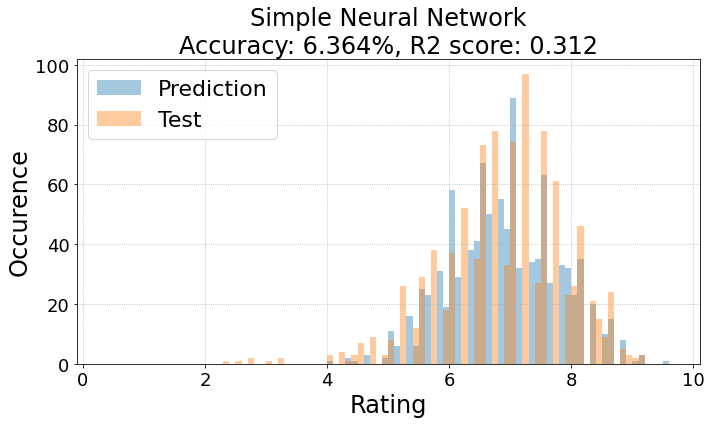

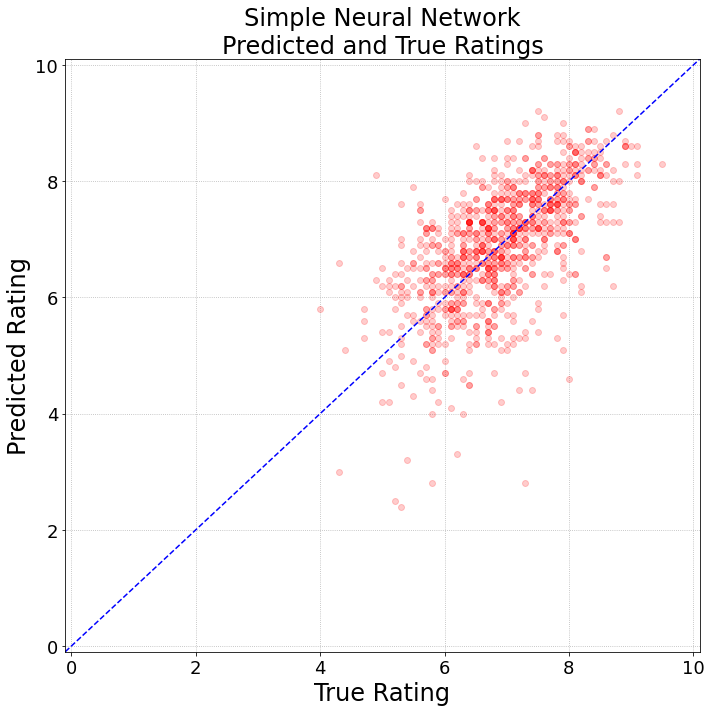

In [48]:
y_pred = np.round(model.predict(X_test_s),1)
plot_hist_n_scatter(y_pred,y_test, "Simple Neural Network")

In [49]:
model2 = tf.keras.Sequential()

model2.add(Dense(hidden_units1, kernel_initializer='normal', activation='selu'))
model2.add(Dropout(0.07))
model2.add(BatchNormalization())


model2.add(Dense(hidden_units2, kernel_initializer='normal', activation='selu'))
model2.add(Dropout(0.07))
model2.add(BatchNormalization())


model2.add(Dense(hidden_units3, kernel_initializer='normal', activation='selu'))
model2.add(Dropout(0.07))
model2.add(BatchNormalization())

model2.add(Dense(1, kernel_initializer='normal', activation='linear'))

In [50]:
model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005),
              loss=tf.keras.losses.SquaredHinge(),
              metrics=['accuracy'])
with tf.device("/device:XLA_GPU:0"):
    history = model2.fit(x=X_train_s,
                        y=y_train.values,
                        batch_size=64,
                        epochs=150,
                        validation_split=0.15
                        )
print(model2.summary())


Train on 3363 samples, validate on 594 samples
Epoch 1/150
3363/3363 [==============================] - 0s 143us/sample - loss: 54.2038 - accuracy: 0.0000e+00 - val_loss: 0.4384 - val_accuracy: 0.0000e+00
Epoch 2/150
3363/3363 [==============================] - 0s 99us/sample - loss: 0.0163 - accuracy: 0.0000e+00 - val_loss: 1.7713e-04 - val_accuracy: 0.0000e+00
Epoch 3/150
3363/3363 [==============================] - 0s 103us/sample - loss: 0.0063 - accuracy: 0.0000e+00 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 4/150
3363/3363 [==============================] - 0s 103us/sample - loss: 0.0058 - accuracy: 0.0000e+00 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 5/150
3363/3363 [==============================] - 0s 102us/sample - loss: 0.0024 - accuracy: 0.0000e+00 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 6/150
3363/3363 [==============================] - 0s 104us/sample - loss: 0.0014 - accuracy: 0.0000e+00 - val_loss: 0.0000e+00 - val_accuracy: 0.

3363/3363 [==============================] - 0s 101us/sample - loss: 1.7830e-04 - accuracy: 0.0000e+00 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 51/150
3363/3363 [==============================] - 0s 100us/sample - loss: 2.0603e-06 - accuracy: 0.0000e+00 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 52/150
3363/3363 [==============================] - 0s 104us/sample - loss: 0.0000e+00 - accuracy: 0.0000e+00 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 53/150
3363/3363 [==============================] - 0s 101us/sample - loss: 2.3748e-06 - accuracy: 0.0000e+00 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 54/150
3363/3363 [==============================] - 0s 100us/sample - loss: 8.3325e-07 - accuracy: 0.0000e+00 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 55/150
3363/3363 [==============================] - 0s 105us/sample - loss: 8.6000e-04 - accuracy: 0.0000e+00 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 56/150
3363

3363/3363 [==============================] - 0s 100us/sample - loss: 0.0000e+00 - accuracy: 0.0000e+00 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 100/150
3363/3363 [==============================] - 0s 104us/sample - loss: 0.0000e+00 - accuracy: 0.0000e+00 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 101/150
3363/3363 [==============================] - 0s 101us/sample - loss: 0.0000e+00 - accuracy: 0.0000e+00 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 102/150
3363/3363 [==============================] - 0s 100us/sample - loss: 0.0000e+00 - accuracy: 0.0000e+00 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 103/150
3363/3363 [==============================] - 0s 106us/sample - loss: 0.0000e+00 - accuracy: 0.0000e+00 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 104/150
3363/3363 [==============================] - 0s 101us/sample - loss: 0.0000e+00 - accuracy: 0.0000e+00 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 105/15

3363/3363 [==============================] - 0s 107us/sample - loss: 0.0000e+00 - accuracy: 0.0000e+00 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 149/150
3363/3363 [==============================] - 0s 103us/sample - loss: 0.0000e+00 - accuracy: 0.0000e+00 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 150/150
3363/3363 [==============================] - 0s 107us/sample - loss: 0.0000e+00 - accuracy: 0.0000e+00 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              multiple                  39936     
_________________________________________________________________
dropout_3 (Dropout)          multiple                  0         
_________________________________________________________________
batch_normalization_3 (Batch multiple                  4096      
_____________________________

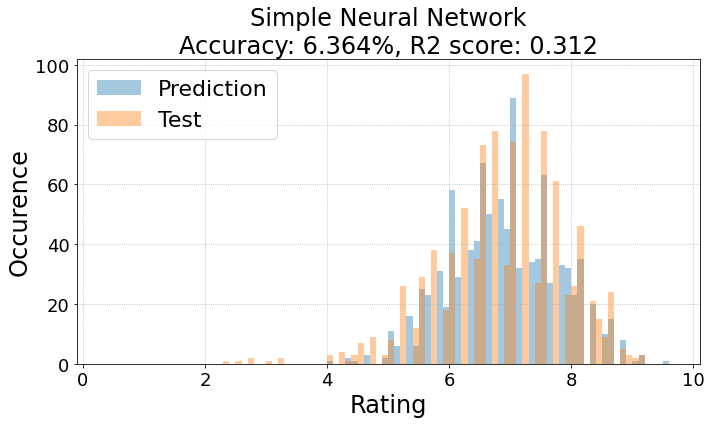

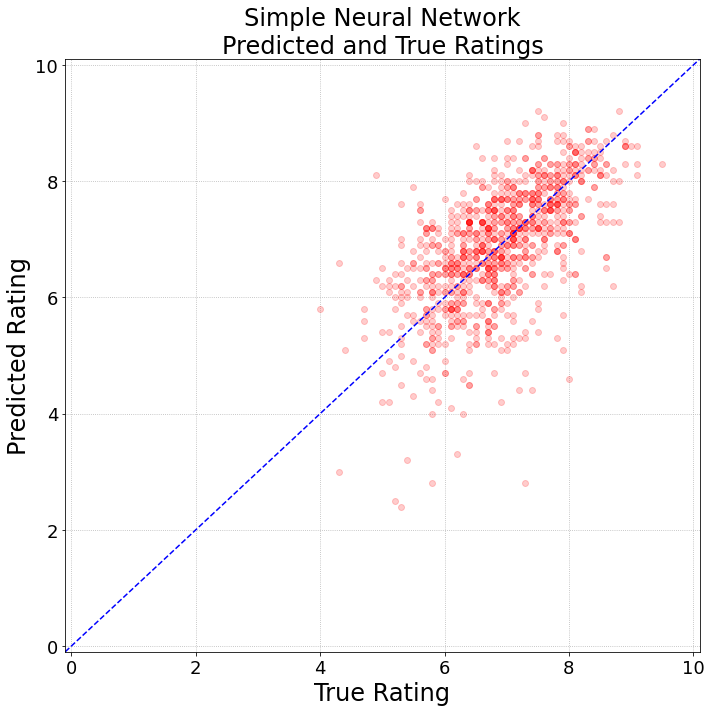

In [51]:
y_pred = np.round(model.predict(X_test_s),1)
plot_hist_n_scatter(y_pred,y_test, "Simple Neural Network")

This is the point when I saw that nothing can improve this... Seems like even though it is continous, it isn't really like that...